![](grid.png)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 126 GB / available: 103 GB / percent used: 17.8 %


# Try to reproduce grid_noro

/modipsl/modeles/LMDZ/libf/phylmd/grid_noro_m.F90

Finally /modipsl/modeles/LMDZ/libf/dynphy_lonlat/phylmd/etat0dyn_netcdf.F90, either we compute the orographic parameters with grid_noro, either we read it:

In [ ]:
# !--- READ SUB-CELL SCALES PARAMETERS FROM A FILE (AT RIGHT RESOLUTION)
#   OPEN(UNIT=66,FILE=oroparam,STATUS='OLD',IOSTAT=ierr)
#   IF(ierr==0.AND.read_orop) THEN
#     CLOSE(UNIT=66)
#     CALL read_noro(lon_in,lat_in,oroparam,                                     &
#                    phis,zmea0,zstd0,zsig0,zgam0,zthe0,zpic0,zval0,masque)
#   ELSE
# !--- CALL OROGRAPHY MODULE TO COMPUTE FIELDS
#     CALL grid_noro(lon_rad,lat_rad,relief_hi,lon_in,lat_in,                    &
#                    phis,zmea0,zstd0,zsig0,zgam0,zthe0,zpic0,zval0,masque)
#   END IF
#   phis = phis * 9.81
#   phis(iml,:) = phis(1,:)
#   DEALLOCATE(relief_hi,lon_rad,lat_rad)

In [ ]:
# !-------------------------------------------------------------------------------
# !
# SUBROUTINE grid_noro(xd,yd,zd,x,y,zphi,zmea,zstd,zsig,zgam,zthe,zpic,zval,mask)
# !
# !-------------------------------------------------------------------------------
# ! Author: F. Lott (see also Z.X. Li, A. Harzallah et L. Fairhead)
# !-------------------------------------------------------------------------------
# ! Purpose: Compute the Parameters of the SSO scheme as described in LOTT &MILLER
# !         (1997) and LOTT(1999).
# !-------------------------------------------------------------------------------
# ! Comments:
# !  * Target points are on a rectangular grid:
# !      iim+1 latitudes including North and South Poles;
# !      jjm+1 longitudes, with periodicity jjm+1=1.
# !  * At the poles, the fields value is repeated jjm+1 time.
# !  * The parameters a,b,c,d represent the limits of the target gridpoint region.
# !    The means over this region are calculated from USN data, ponderated by a
# !    weight proportional to the surface occupated by the data inside the model
# !    gridpoint area. In most circumstances, this weight is the ratio between the
# !    surfaces of the USN gridpoint area and the model gridpoint area. 
# !
# !           (c)
# !        ----d-----
# !        | . . . .|
# !        |        |
# !     (b)a . * . .b(a)
# !        |        |
# !        | . . . .|
# !        ----c-----
# !           (d)
# !  * Hard-coded US Navy dataset dimensions (imdp=2160 ; jmdp=1080) have been
# !    removed (ALLOCATABLE used).
# !  * iext (currently 10% of imdp) represents the margin to ensure output cells
# !    on the edge are contained in input cells.
# !===============================================================================



# !-------------------------------------------------------------------------------
# ! Arguments:
#   REAL, INTENT(IN)  :: xd(:), yd(:)  !--- INPUT  COORDINATES     (imdp) (jmdp)
#   REAL, INTENT(IN)  :: zd(:,:)       !--- INPUT  FIELD           (imdp,jmdp)
#   REAL, INTENT(IN)  :: x(:), y(:)    !--- OUTPUT COORDINATES     (imar+1) (jmar)
#   REAL, INTENT(OUT) :: zphi(:,:)     !--- GEOPOTENTIAL           (imar+1,jmar)
#   REAL, INTENT(OUT) :: zmea(:,:)     !--- MEAN OROGRAPHY         (imar+1,jmar)
#   REAL, INTENT(OUT) :: zstd(:,:)     !--- STANDARD DEVIATION     (imar+1,jmar)
#   REAL, INTENT(OUT) :: zsig(:,:)     !--- SLOPE                  (imar+1,jmar)
#   REAL, INTENT(OUT) :: zgam(:,:)     !--- ANISOTROPY             (imar+1,jmar)
#   REAL, INTENT(OUT) :: zthe(:,:)     !--- SMALL AXIS ORIENTATION (imar+1,jmar)
#   REAL, INTENT(OUT) :: zpic(:,:)     !--- MAXIMUM ALTITITUDE     (imar+1,jmar)
#   REAL, INTENT(OUT) :: zval(:,:)     !--- MINIMUM ALTITITUDE     (imar+1,jmar)
#   REAL, INTENT(OUT) :: mask(:,:)     !--- MASK                   (imar+1,jmar)
# !-------------------------------------------------------------------------------
# ! Local variables:
#   CHARACTER(LEN=256) :: modname="grid_noro"
#   REAL, ALLOCATABLE :: xusn(:), yusn(:)           ! dim (imdp+2*iext) (jmdp+2)
#   REAL, ALLOCATABLE :: zusn(:,:)                  ! dim (imdp+2*iext,jmdp+2)
# ! CORRELATIONS OF OROGRAPHY GRADIENT              ! dim (imar+1,jmar)
#   REAL, ALLOCATABLE :: ztz(:,:), zxtzx(:,:), zytzy(:,:), zxtzy(:,:), weight(:,:)
# ! CORRELATIONS OF USN OROGRAPHY GRADIENTS         ! dim (imar+2*iext,jmdp+2)
#   REAL, ALLOCATABLE :: zxtzxusn(:,:), zytzyusn(:,:), zxtzyusn(:,:)
#   REAL, ALLOCATABLE :: num_tot(:,:), num_lan(:,:) ! dim (imar+1,jmar)
#   REAL, ALLOCATABLE :: a(:), b(:)                 ! dim (imar+1)
#   REAL, ALLOCATABLE :: c(:), d(:)                 ! dim (jmar)
#   LOGICAL :: masque_lu
#   INTEGER :: i, ii, imdp, imar, iext
#   INTEGER :: j, jj, jmdp, jmar, nn
#   REAL    :: xpi, zdeltax, zlenx, weighx, xincr,  zweinor, xk, xl, xm
#   REAL    :: rad, zdeltay, zleny, weighy, masque, zweisud, xp, xq, xw

# On part du fichier Relief.nc

In [2]:
relief = xr.open_dataset('/home/mlalande/notebooks/Relief.nc').RELIEF
relief

<xarray.DataArray 'RELIEF' (latitude: 1080, longitude: 2160)>
[2332800 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -179.9167 -179.75 ... 179.75 179.9167
  * latitude   (latitude) float32 89.91655 89.74982 ... -89.74982 -89.91655
Attributes:
    units:     m
    title:     RELIEF
    lon_name:  RELIEF

In [2]:
# Grille cible
path = '/data/mlalande/ELC-144x142x79_clim'
limit = xr.open_dataset(path+'/Output/Boundary/ELC-144x142x79_clim_limit.nc')
grilles_gcm = xr.open_dataset(path+'/Output/Grid/ELC-144x142x79_grilles_gcm.nc')
start = xr.open_dataset(path+'/Output/Restart/ELC-144x142x79_clim_start.nc')
startphy = xr.open_dataset(path+'/Output/Restart/ELC-144x142x79_clim_startphy.nc')

orog_fx_IPSL = xr.open_dataarray('/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/orog/gr/latest/orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc')

In [7]:
start

<xarray.Dataset>
Dimensions:   (index: 100, rlatu: 143, rlatv: 142, rlonu: 145, rlonv: 145, sig: 80, sigs: 79, temps: 1)
Coordinates:
  * rlonu     (rlonu) float64 -3.12 -3.076 -3.033 -2.989 ... 3.076 3.12 3.163
  * rlatu     (rlatu) float64 1.571 1.549 1.527 1.504 ... -1.527 -1.549 -1.571
  * rlonv     (rlonv) float64 -3.142 -3.098 -3.054 -3.011 ... 3.054 3.098 3.142
  * rlatv     (rlatv) float64 1.56 1.538 1.515 1.493 ... -1.515 -1.538 -1.56
  * temps     (temps) datetime64[ns] 1979-01-01
Dimensions without coordinates: index, sig, sigs
Data variables:
    controle  (index) float64 ...
    nivsigs   (sigs) float64 ...
    nivsig    (sig) float64 ...
    ap        (sig) float64 ...
    bp        (sig) float64 ...
    presnivs  (sigs) float64 ...
    cu        (rlatu, rlonu) float64 ...
    cv        (rlatv, rlonv) float64 ...
    aire      (rlatu, rlonv) float64 ...
    phisinit  (rlatu, rlonv) float64 0.0 0.0 0.0 ... 2.787e+04 2.787e+04
    ucov      (temps, sigs, rlatu, rlonu) float64 ...
    vcov      (temps, sigs, rlatv, rlonv) float64 ...
    teta      (temps, sigs, rlatu, rlonv) float64 ...
    H2Ov      (temps, sigs, rlatu, rlonv) float64 ...
    H2Ol      (temps, sigs, rlatu, rlonv) float64 ...
    H2Oi      (temps, sigs, rlatu, rlonv) float64 ...
    Aga       (temps, sigs, rlatu, rlonv) float64 ...
    masse     (temps, sigs, rlatu, rlonv) float64 ...
    ps        (temps, rlatu, rlonv) float64 ...
Attributes:
    title:    Fichier demarrage dynamique

In [258]:
orog_fx_IPSL

<xarray.DataArray 'orog' (lat: 143, lon: 144)>
array([[2841.648 , 2841.648 , 2841.648 , ..., 2841.648 , 2841.648 , 2841.648 ],
       [2688.9688, 2697.9724, 2708.5688, ..., 2658.9578, 2668.209 , 2677.9058],
       [2618.7102, 2638.589 , 2658.8015, ..., 2562.443 , 2580.6404, 2599.4429],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:         Surface Altitude
    units:             m
    online_operation:  once
    cell_methods:      area: mean
    cell_measures:     area: areacella
    standard_name:     surface_altitude
    description:       The surface called 'surface' means the lower boundary ...

In [5]:
#   REAL, INTENT(IN)  :: xd(:), yd(:)  !--- INPUT  COORDINATES     (imdp) (jmdp)
#   REAL, INTENT(IN)  :: zd(:,:)       !--- INPUT  FIELD           (imdp,jmdp)
#   REAL, INTENT(IN)  :: x(:), y(:)    !--- OUTPUT COORDINATES     (imar+1) (jmar)

In [277]:
# Needs to be in radian
xd = np.deg2rad(relief.longitude)
yd = np.deg2rad(relief.latitude)
zd = relief.transpose()

# Radians? I don't know yet
x = orog_fx_IPSL.lon
y = orog_fx_IPSL.lat.sortby('lat', ascending=False)

imdp = xd.size
jmdp = yd.size

In [185]:
relief

<xarray.DataArray 'RELIEF' (latitude: 1080, longitude: 2160)>
array([[   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       ...,
       [2896.55, 2909.02, 2922.08, ..., 2908.58, 2896.3 , 2889.97],
       [2877.79, 2896.11, 2913.77, ..., 2895.6 , 2877.48, 2866.01],
       [2866.33, 2890.31, 2912.04, ..., 2889.78, 2865.99, 2848.64]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.9167 -179.75 ... 179.75 179.9167
  * latitude   (latitude) float32 89.91655 89.74982 ... -89.74982 -89.91655
Attributes:
    units:     m
    title:     RELIEF
    lon_name:  RELIEF

In [186]:
iext = int(imdp/10) #  To extend for computation
xpi = np.pi # Pi
rad = 6371229 # Rayon de la Terre en mètres
zdeltay = 2*xpi/jmdp*rad # Delta y en mètres (delta latitude)
zdeltay

37066.307816181936

# Erreur zdeltay ? Il y a un facteur 2

In [ ]:
def deg2km(nlon, nlat, lat):
    # Gives the size of a grid cell in km at the corresponding latitude
    R_earth = 6371
    x = 2*np.pi*R_earth/nlon*np.cos(np.deg2rad(lat))
    y = np.pi*R_earth/nlat # on ne multiplie pas par 2 car la latitude a slt 180°
    return {'x': x, 'y': y, 'units': 'km'}

## Check with my function

In [56]:
u.deg2km(nlon=relief.longitude.size, nlat=relief.latitude.size, lat=0)

{'x': 18.532487774093124, 'y': 18.532487774093124, 'units': 'km'}

# EXTENSION OF THE INPUT DATABASE TO PROCEED COMPUTATIONS AT BOUNDARIES:

In [ ]:
# !--- EXTENSION OF THE INPUT DATABASE TO PROCEED COMPUTATIONS AT BOUNDARIES:
#   ALLOCATE(xusn(imdp+2*iext))
#   xusn(1     +iext:imdp  +iext)=xd(:)
#   xusn(1          :       iext)=xd(1+imdp-iext:imdp)-2.*xpi
#   xusn(1+imdp+iext:imdp+2*iext)=xd(1          :iext)+2.*xpi

#   ALLOCATE(yusn(jmdp+2))
#   yusn(1       )=yd(1)   +(yd(1)   -yd(2))
#   yusn(2:jmdp+1)=yd(:)
#   yusn(  jmdp+2)=yd(jmdp)+(yd(jmdp)-yd(jmdp-1))

#   ALLOCATE(zusn(imdp+2*iext,jmdp+2))
#   zusn(1       +iext:imdp  +iext,2:jmdp+1)=zd  (:                   ,     :)
#   zusn(1            :       iext,2:jmdp+1)=zd  (imdp-iext+1:imdp    ,     :)
#   zusn(1+imdp  +iext:imdp+2*iext,2:jmdp+1)=zd  (1:iext              ,     :)
#   zusn(1            :imdp/2+iext,       1)=zusn(1+imdp/2:imdp  +iext,     2)
#   zusn(1+imdp/2+iext:imdp+2*iext,       1)=zusn(1       :imdp/2+iext,     2)
#   zusn(1            :imdp/2+iext,  jmdp+2)=zusn(1+imdp/2:imdp  +iext,jmdp+1)
#   zusn(1+imdp/2+iext:imdp+2*iext,  jmdp+2)=zusn(1       :imdp/2+iext,jmdp+1)

In [187]:
xd

<xarray.DataArray 'longitude' (longitude: 2160)>
array([-3.1401389, -3.1372292, -3.1343198, ...,  3.1343198,  3.1372292,
        3.1401389], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.9167 -179.75 ... 179.75 179.9167

In [188]:
xusn = np.zeros(imdp+2*iext)
                
xusn[iext:imdp+iext] = xd.values
xusn[:iext] = xd[imdp-iext:imdp]-2.*xpi
xusn[imdp+iext:imdp+2*iext] = xd[:iext]+2.*xpi
xusn

array([-3.76845574, -3.76554608, -3.76263499, ...,  3.76263499,
        3.76554608,  3.76845574])

In [189]:
yd

<xarray.DataArray 'latitude' (latitude: 1080)>
array([ 1.5693399,  1.5664299,  1.5635198, ..., -1.5635198, -1.5664299,
       -1.5693399], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 89.91655 89.74982 ... -89.74982 -89.91655

In [190]:
yusn = np.zeros(jmdp+2)
yusn[0] = yd[0].values + yd[0].values - yd[1].values
yusn[1:jmdp+1] = yd.values
yusn[-1] = yd[-1]+(yd[-1]-yd[-2])
yusn

array([ 1.57224989,  1.56933987,  1.56642985, ..., -1.56642985,
       -1.56933987, -1.57224989])

In [247]:
# np.pad can simply things... and in the future xr.pad even better
zusn = np.ones((imdp+2*iext,jmdp+2))

zusn[iext:imdp+iext,1:jmdp+1] = zd.values

zusn[:iext,1:jmdp+1] = zd[imdp-iext:imdp,:]
zusn[imdp+iext:imdp+2*iext,1:jmdp+1] = zd[:iext,:]

zusn[:,0] = zusn[:,1]
zusn[:,-1] = zusn[:,-2]

zusn.shape

(2592, 1082)

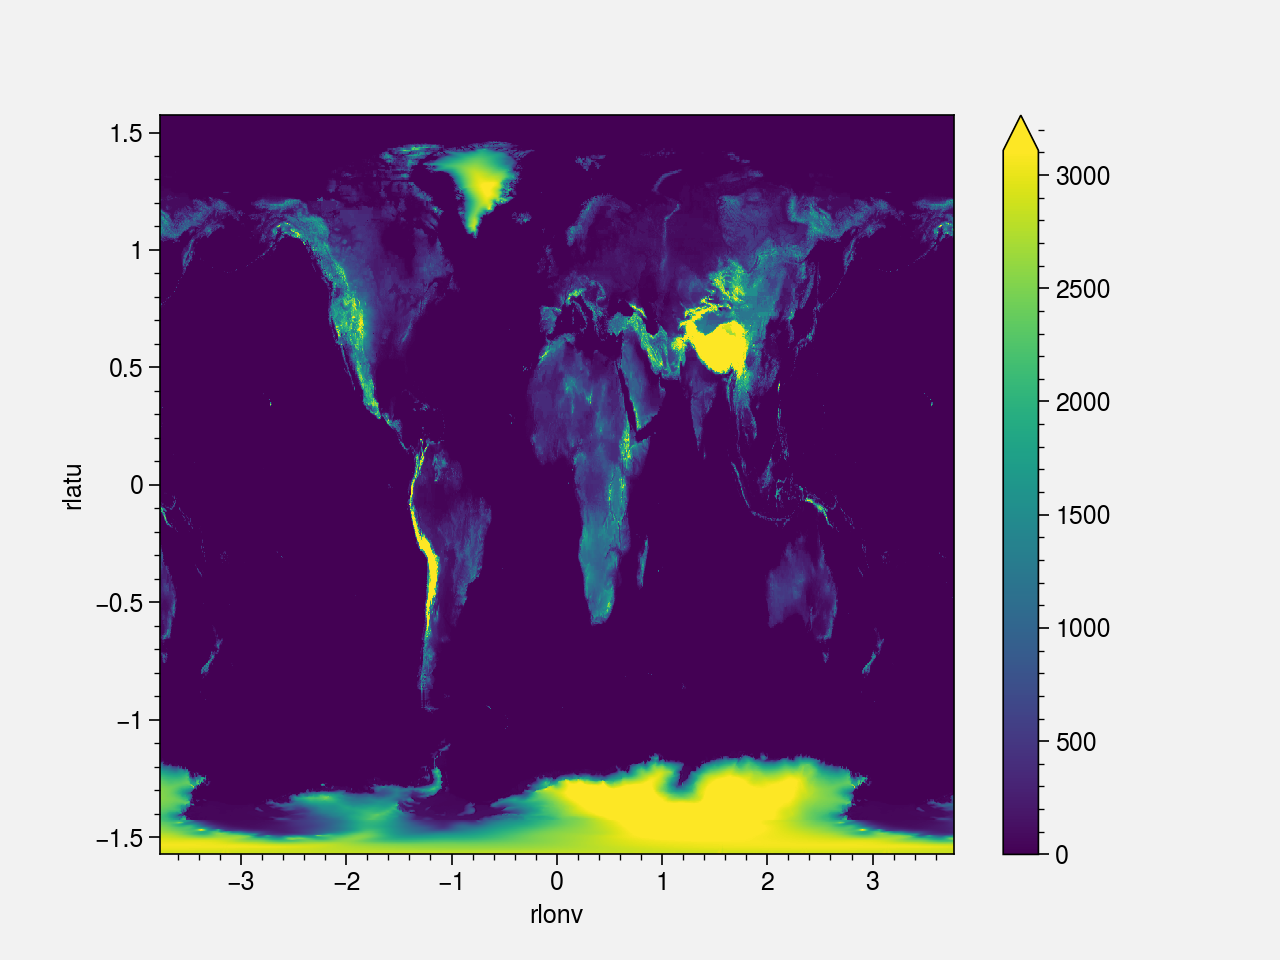

In [250]:
xr.DataArray(zusn.transpose(), coords=[yusn, xusn], dims=['rlatu', 'rlonv']).plot(robust=True)

# COMPUTE LIMITS OF MODEL GRIDPOINT AREA (REGULAR GRID)

In [ ]:
# !--- COMPUTE LIMITS OF MODEL GRIDPOINT AREA (REGULAR GRID)
#   ALLOCATE(a(imar+1),b(imar+1))
#   b(1:imar)=(x(1:imar  )+ x(2:imar+1))/2.0
#   b(imar+1)= x(  imar+1)+(x(  imar+1)-x(imar))/2.0
#   a(1)=x(1)-(x(2)-x(1))/2.0
#   a(2:imar+1)= b(1:imar)

#   ALLOCATE(c(jmar),d(jmar))
#   d(1:jmar-1)=(y(1:jmar-1)+ y(2:jmar))/2.0
#   d(  jmar  )= y(  jmar  )+(y(  jmar)-y(jmar-1))/2.0
#   c(1)=y(1)-(y(2)-y(1))/2.0
#   c(2:jmar)=d(1:jmar-1)


# !           (c)
# !        ----d-----
# !        | . . . .|
# !        |        |
# !     (b)a . * . .b(a)
# !        |        |
# !        | . . . .|
# !        ----c-----
# !           (d)

In [256]:
imar = 144
jmar = 142

In [304]:
grilles_gcm

<xarray.Dataset>
Dimensions:   (latu: 143, latv: 142, lev: 79, lonu: 145, lonv: 145)
Coordinates:
  * lonu      (lonu) float32 181.25 183.75 186.25 ... 536.25 538.75 541.25
  * lonv      (lonv) float32 180.0 182.5 185.0 187.5 ... 532.5 535.0 537.5 540.0
  * latu      (latu) float32 90.0 88.73239 87.46479 ... -88.73239 -90.0
  * latv      (latv) float32 89.366196 88.098595 ... -88.098595 -89.366196
Dimensions without coordinates: lev
Data variables:
    grille_u  (latu, lonu) float32 ...
    grille_v  (latv, lonv) float32 ...
    grille_s  (latu, lonv) float32 ...
    presnivs  (lev) float32 ...
    phis      (latu, lonv) float32 ...
    aire      (latu, lonv) float32 ...
    mask      (latu, lonv) int32 ...

In [286]:
xa

<xarray.DataArray 'lon' (lon: 144)>
array([  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,  22.5,
        25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,  45. ,  47.5,
        50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,  67.5,  70. ,  72.5,
        75. ,  77.5,  80. ,  82.5,  85. ,  87.5,  90. ,  92.5,  95. ,  97.5,
       100. , 102.5, 105. , 107.5, 110. , 112.5, 115. , 117.5, 120. , 122.5,
       125. , 127.5, 130. , 132.5, 135. , 137.5, 140. , 142.5, 145. , 147.5,
       150. , 152.5, 155. , 157.5, 160. , 162.5, 165. , 167.5, 170. , 172.5,
       175. , 177.5, 180. , 182.5, 185. , 187.5, 190. , 192.5, 195. , 197.5,
       200. , 202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5, 220. , 222.5,
       225. , 227.5, 230. , 232.5, 235. , 237.5, 240. , 242.5, 245. , 247.5,
       250. , 252.5, 255. , 257.5, 260. , 262.5, 265. , 267.5, 270. , 272.5,
       275. , 277.5, 280. , 282.5, 285. , 287.5, 290. , 292.5, 295. , 297.5,
       300. , 302.5, 305. , 307.5, 310. , 312.5, 315. , 317.5, 320. , 322.5,
       325. , 327.5, 330. , 332.5, 335. , 337.5, 340. , 342.5, 345. , 347.5,
       350. , 352.5, 355. , 357.5], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    axis:           X
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east

In [296]:
((x[:-1].values+x[1:].values)/2).shape

(143,)

In [289]:
x[-1].values + (x[-1].values-x[-2].values)/2.0

358.75

In [302]:
b[:imar].shape

(144,)

In [293]:
a = np.zeros(imar+1)
b = np.zeros(imar+1)

b[:imar] = (x[:-1].values+x[1:].values)/2
b[imar] = x[-1].values + (x[-1].values-x[-2].values)/2.0
# a[0] = x[0]-[x[2]-x[0]]/2.0
# a[1:imar+1] = b[:imar]

ValueError: could not broadcast input array from shape (143) into shape (144)

In [ ]:
#   ALLOCATE(c(jmar),d(jmar))
#   d(1:jmar-1)=(y(1:jmar-1)+ y(2:jmar))/2.0
#   d(  jmar  )= y(  jmar  )+(y(  jmar)-y(jmar-1))/2.0
#   c(1)=y(1)-(y(2)-y(1))/2.0
#   c(2:jmar)=d(1:jmar-1)

In [255]:
orog_fx_IPSL

<xarray.DataArray 'orog' (lat: 143, lon: 144)>
array([[2841.648 , 2841.648 , 2841.648 , ..., 2841.648 , 2841.648 , 2841.648 ],
       [2688.9688, 2697.9724, 2708.5688, ..., 2658.9578, 2668.209 , 2677.9058],
       [2618.7102, 2638.589 , 2658.8015, ..., 2562.443 , 2580.6404, 2599.4429],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:         Surface Altitude
    units:             m
    online_operation:  once
    cell_methods:      area: mean
    cell_measures:     area: areacella
    standard_name:     surface_altitude
    description:       The surface called 'surface' means the lower boundary ...

In [253]:
x

<xarray.DataArray 'lonv' (lonv: 145)>
array([180. , 182.5, 185. , 187.5, 190. , 192.5, 195. , 197.5, 200. , 202.5,
       205. , 207.5, 210. , 212.5, 215. , 217.5, 220. , 222.5, 225. , 227.5,
       230. , 232.5, 235. , 237.5, 240. , 242.5, 245. , 247.5, 250. , 252.5,
       255. , 257.5, 260. , 262.5, 265. , 267.5, 270. , 272.5, 275. , 277.5,
       280. , 282.5, 285. , 287.5, 290. , 292.5, 295. , 297.5, 300. , 302.5,
       305. , 307.5, 310. , 312.5, 315. , 317.5, 320. , 322.5, 325. , 327.5,
       330. , 332.5, 335. , 337.5, 340. , 342.5, 345. , 347.5, 350. , 352.5,
       355. , 357.5, 360. , 362.5, 365. , 367.5, 370. , 372.5, 375. , 377.5,
       380. , 382.5, 385. , 387.5, 390. , 392.5, 395. , 397.5, 400. , 402.5,
       405. , 407.5, 410. , 412.5, 415. , 417.5, 420. , 422.5, 425. , 427.5,
       430. , 432.5, 435. , 437.5, 440. , 442.5, 445. , 447.5, 450. , 452.5,
       455. , 457.5, 460. , 462.5, 465. , 467.5, 470. , 472.5, 475. , 477.5,
       480. , 482.5, 485. , 487.5, 490. , 492.5, 495. , 497.5, 500. , 502.5,
       505. , 507.5, 510. , 512.5, 515. , 517.5, 520. , 522.5, 525. , 527.5,
       530. , 532.5, 535. , 537.5, 540. ], dtype=float32)
Coordinates:
  * lonv     (lonv) float32 180.0 182.5 185.0 187.5 ... 532.5 535.0 537.5 540.0
Attributes:
    units:      degrees_east
    long_name:  Longitude

In [252]:
grilles_gcm

<xarray.Dataset>
Dimensions:   (latu: 143, latv: 142, lev: 79, lonu: 145, lonv: 145)
Coordinates:
  * lonu      (lonu) float32 181.25 183.75 186.25 ... 536.25 538.75 541.25
  * lonv      (lonv) float32 180.0 182.5 185.0 187.5 ... 532.5 535.0 537.5 540.0
  * latu      (latu) float32 90.0 88.73239 87.46479 ... -88.73239 -90.0
  * latv      (latv) float32 89.366196 88.098595 ... -88.098595 -89.366196
Dimensions without coordinates: lev
Data variables:
    grille_u  (latu, lonu) float32 ...
    grille_v  (latv, lonv) float32 ...
    grille_s  (latu, lonv) float32 ...
    presnivs  (lev) float32 ...
    phis      (latu, lonv) float32 ...
    aire      (latu, lonv) float32 ...
    mask      (latu, lonv) int32 ...

In [278]:
x

<xarray.DataArray 'lon' (lon: 144)>
array([  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,  22.5,
        25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,  45. ,  47.5,
        50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,  67.5,  70. ,  72.5,
        75. ,  77.5,  80. ,  82.5,  85. ,  87.5,  90. ,  92.5,  95. ,  97.5,
       100. , 102.5, 105. , 107.5, 110. , 112.5, 115. , 117.5, 120. , 122.5,
       125. , 127.5, 130. , 132.5, 135. , 137.5, 140. , 142.5, 145. , 147.5,
       150. , 152.5, 155. , 157.5, 160. , 162.5, 165. , 167.5, 170. , 172.5,
       175. , 177.5, 180. , 182.5, 185. , 187.5, 190. , 192.5, 195. , 197.5,
       200. , 202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5, 220. , 222.5,
       225. , 227.5, 230. , 232.5, 235. , 237.5, 240. , 242.5, 245. , 247.5,
       250. , 252.5, 255. , 257.5, 260. , 262.5, 265. , 267.5, 270. , 272.5,
       275. , 277.5, 280. , 282.5, 285. , 287.5, 290. , 292.5, 295. , 297.5,
       300. , 302.5, 305. , 307.5, 310. , 312.5, 315. , 317.5, 320. , 322.5,
       325. , 327.5, 330. , 332.5, 335. , 337.5, 340. , 342.5, 345. , 347.5,
       350. , 352.5, 355. , 357.5], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    axis:           X
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east

In [172]:
xr.DataArray(, coords=[zd.latitude, zd.longitude], dims=['laitude', 'longitude'])

<xarray.DataArray (laitude: 1080, longitude: 2160)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * laitude    (laitude) float32 89.91655 89.74982 ... -89.74982 -89.91655
  * longitude  (longitude) float32 -179.9167 -179.75 ... 179.75 179.9167

In [169]:
zd.values.pad

array([[   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       ...,
       [2896.55, 2909.02, 2922.08, ..., 2908.58, 2896.3 , 2889.97],
       [2877.79, 2896.11, 2913.77, ..., 2895.6 , 2877.48, 2866.01],
       [2866.33, 2890.31, 2912.04, ..., 2889.78, 2865.99, 2848.64]],
      dtype=float32)